# Visualize the data

Before we can start any training, you need to get a feel for the data you have and ask some question.

## Setup

In [8]:
# import the necessary libraries
from matplotlib import pyplot as plt
import imutils
import numpy as np
import argparse
import cv2
import os
from PIL import Image

# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


# View the data

## Lets make sure we have an even (unbiased) number of examples for each type

Or we might teach our model that right fingerprints are more common than left ones?

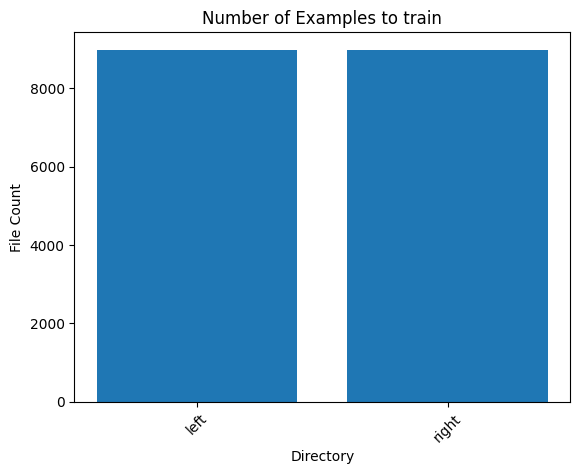

In [9]:
directories = [scratch_path + "/train/left/", scratch_path + "/train/right/"]

file_data = {}

for directory in directories:
    file_count = sum(len(files) for _, _, files in os.walk(directory))
    dir_name = os.path.basename(directory.rstrip('/'))
    file_data[dir_name] = file_count

# Extract filenames and file counts from the file_data dictionary
filenames = list(file_data.keys())
file_counts = list(file_data.values())

# Create the histogram
plt.bar(filenames, file_counts)

# Set the labels and title
plt.xlabel('Directory')
plt.ylabel('File Count')
plt.title('Number of Examples to train')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the histogram
plt.show()


In [10]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

## Implement OpenCV image loading script

In [11]:
# load the input image and display it to our screen
args = {
	"image": scratch_path + "/train/left/1__M_Left_index_finger_CR.png"
}

## Load the image from disk and grab spatial dimensions

width: 96 pixels
heigth: 103 pixels
channels: 3


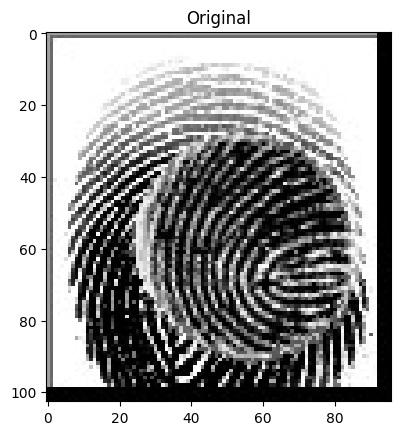

In [12]:
# loads the image set above from disk into image
image = cv2.imread(args["image"])
(h, w, c) = image.shape[:3]

# display the image dimensions
print("width: {} pixels".format(image.shape[1]))
print("heigth: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))

# show the image 
plt_imshow("Original", image)

# save the image back to disk and wait for keypress
#cv2.imwrite(scratch_path + "/train_lr/left/1__M_Left_index_finger_CR.png", image)

## What does this image look like

We use Pillow to open an image (with PIL.Image.open), and immediately convert the PIL.Image.Image object into an 8-bit (dtype=uint8) numpy array. Each inner list represents a pixel.Since it's a black and white image, R, G, and B are all similar. Matplotlib supports float32 and uint8 data types. For grayscale, Matplotlib supports only float32. If your array data does not meet one of these descriptions, you need to rescale it.

In [13]:
img = np.asarray(Image.open(scratch_path + "/train/left/1__M_Left_index_finger_CR.png"))
print(repr(img))

array([[159, 159, 161, ...,   0,   0,   2],
       [163,  99, 111, ...,   0,   1,   1],
       [157, 113, 244, ...,   1,   0,   0],
       ...,
       [  0,   1,   0, ...,   3,   0,   2],
       [  0,   5,   0, ...,   1,   0,   2],
       [  1,   0,   0, ...,   0,   0,   2]], dtype=uint8)


Sometimes you want to enhance the contrast in your image, or expand the contrast in a particular region while sacrificing the detail in colors that don't vary much, or don't matter. A good tool to find interesting regions is the histogram. To create a histogram of our image data, we use the hist() function.

(array([3450.,  861.,  651.,  570.,  411.,  315.,  261.,  168.,  180.,
          93.,  117.,  126.,   99.,   81.,   99.,   69.,   81.,   81.,
         102.,   78.,   90.,   54.,   78.,   87.,   60.,   51.,   78.,
          87.,   69.,   48.,   51.,   51.,   57.,   63.,   78.,   69.,
          60.,   45.,   60.,   33.,   69.,   45.,   69.,   42.,   57.,
          66.,   48.,   60.,   51.,   42.,   42.,   36.,   45.,   54.,
          48.,   39.,   57.,   45.,   51.,   66.,   72.,   36.,   60.,
          30.,   39.,   39.,   42.,   42.,   45.,   45.,   63.,   54.,
          36.,   69.,   60.,   48.,   36.,   30.,   33.,   36.,   48.,
          33.,   66.,   96.,   60.,   63.,  117.,   78.,   87.,   72.,
          81.,   48.,   54.,   81.,   60.,   48.,   51.,   54.,   30.,
          57.,   54.,   78.,   63.,   75.,   66.,  426.,   69.,   42.,
          63.,   54.,   78.,   54.,   51.,   87.,   78.,   39.,   54.,
          75.,   69.,   30.,   69.,   48.,   63.,   45.,   54.,   57.,
      

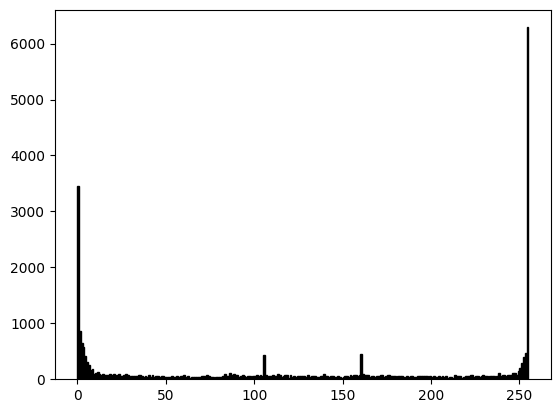

In [14]:
plt.hist(image.ravel(), bins=range(256), fc='k', ec='k')

## Crop the border

There is a border around the image that will make our model think every fingerprint has a border around it, since they don't we want to crop this out. Something to be aware of is if the source ever changes and removes the border we will want to drop the cropping we are about to do.

width: 96 pixels
heigth: 103 pixels
channels: 3


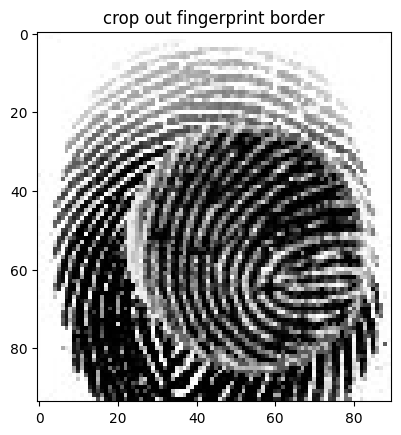

True

In [15]:
# cropping an image with OpenCV is accomplished via simple NumPy
# array slices in startY:endY, startX:endX order
cropped = image[5:99,2:92]

# display the image dimensions
print("width: {} pixels".format(image.shape[1]))
print("heigth: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))

# show the image 
plt_imshow("crop out fingerprint border", cropped)

# save the image
cv2.imwrite(scratch_path + "/train_lr/left/1__M_Left_index_finger_CR.png", cropped)

(array([2025.,  498.,  471.,  420.,  336.,  267.,  204.,  147.,  168.,
          90.,  114.,  123.,   99.,   81.,   99.,   69.,   81.,   81.,
         102.,   78.,   90.,   54.,   78.,   87.,   60.,   51.,   78.,
          87.,   69.,   48.,   51.,   51.,   57.,   63.,   78.,   69.,
          60.,   45.,   60.,   33.,   69.,   45.,   69.,   42.,   57.,
          66.,   48.,   60.,   51.,   42.,   42.,   36.,   45.,   54.,
          48.,   39.,   57.,   45.,   51.,   66.,   72.,   36.,   60.,
          30.,   39.,   39.,   42.,   42.,   45.,   45.,   63.,   54.,
          36.,   69.,   60.,   48.,   36.,   30.,   33.,   36.,   48.,
          33.,   66.,   96.,   60.,   63.,  117.,   78.,   87.,   72.,
          81.,   48.,   54.,   81.,   60.,   48.,   51.,   51.,   30.,
          51.,   39.,   66.,   51.,   48.,   39.,   42.,   48.,   30.,
          51.,   42.,   72.,   48.,   51.,   78.,   78.,   39.,   54.,
          75.,   69.,   30.,   69.,   48.,   63.,   45.,   54.,   57.,
      

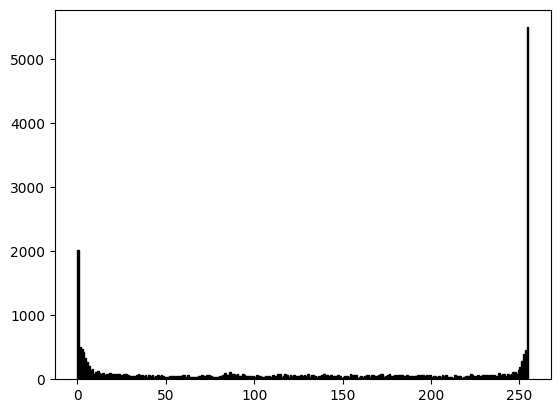

In [16]:
plt.hist(cropped.ravel(), bins=range(256), fc='k', ec='k')

## Image Arithmetic 

Since we do not want our model to always expect that fingerprint images are dark contrast, we should add variability to each image.

In [17]:
# images are NumPy arrays stored as unsigned 8-bit integers (unit8)
# with values in the range [0, 255]; when using the add/subtract
# functions in OpenCV, these values will be *clipped* to this range,
# even if they fall outside the range [0, 255] after applying the
# operation
added = cv2.add(np.uint8([200]), np.uint8([100]))
subtracted = cv2.subtract(np.uint8([50]), np.uint8([100]))
print("max of 255: {}".format(added))
print("min of 0: {}".format(subtracted))

max of 255: [[255]]
min of 0: [[0]]


In [18]:
# using NumPy arithmetic operations (rather than OpenCV operations)
# will result in a modulo ("wrap around") instead of being clipped
# to the range [0, 255]
added = np.uint8([200]) + np.uint8([100])
subtracted = np.uint8([50]) - np.uint8([100])
print("wrap around: {}".format(added))
print("wrap around: {}".format(subtracted))

wrap around: [44]
wrap around: [206]


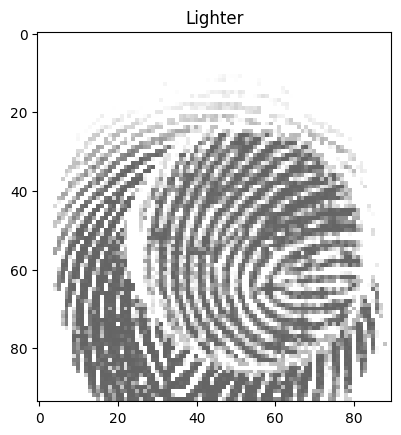

True

In [19]:
# increasing the pixel intensities in our input image by 100 is
# accomplished by constructing a NumPy array that has the *same
# dimensions* as our input image, filling it with ones, multiplying
# it by 100, and then adding the input image and matrix together
M = np.ones(cropped.shape, dtype="uint8") * 100
added = cv2.add(cropped, M)
plt_imshow("Lighter", added)

# save the image
cv2.imwrite(scratch_path + "/train_lr/left/1__M_Left_index_finger_CR_lighter.png", added)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  2025.,   498.,   471.,   420.,
          336.,   267.,   204.,   147.,   168.,    90.,   114., 

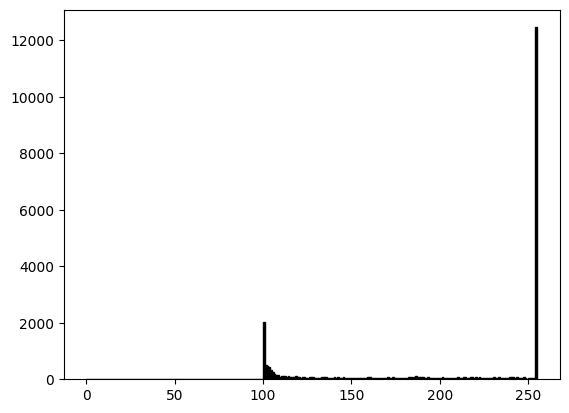

In [20]:
plt.hist(added.ravel(), bins=range(256), fc='k', ec='k')

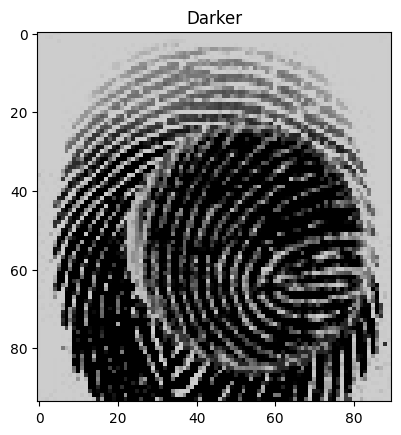

True

In [21]:
# similarly, we can subtract 50 from all pixels in our image and make it
# darker
M = np.ones(cropped.shape, dtype="uint8") * 50
subtracted = cv2.subtract(cropped, M)
plt_imshow("Darker", subtracted)

# save the image
cv2.imwrite(scratch_path + "/train_lr/left/1__M_Left_index_finger_CR_darker.png", subtracted)

(array([7413.,   36.,   45.,   54.,   48.,   39.,   57.,   45.,   51.,
          66.,   72.,   36.,   60.,   30.,   39.,   39.,   42.,   42.,
          45.,   45.,   63.,   54.,   36.,   69.,   60.,   48.,   36.,
          30.,   33.,   36.,   48.,   33.,   66.,   96.,   60.,   63.,
         117.,   78.,   87.,   72.,   81.,   48.,   54.,   81.,   60.,
          48.,   51.,   51.,   30.,   51.,   39.,   66.,   51.,   48.,
          39.,   42.,   48.,   30.,   51.,   42.,   72.,   48.,   51.,
          78.,   78.,   39.,   54.,   75.,   69.,   30.,   69.,   48.,
          63.,   45.,   54.,   57.,   60.,   54.,   60.,   45.,   75.,
          42.,   60.,   63.,   54.,   42.,   45.,   51.,   60.,   87.,
          63.,   63.,   45.,   66.,   57.,   48.,   39.,   66.,   48.,
          27.,   33.,   51.,   54.,   33.,   78.,   60.,   69.,   60.,
          27.,   39.,   51.,   42.,   54.,   72.,   63.,   39.,   60.,
          66.,   45.,   57.,   66.,   81.,   75.,   33.,   57.,   72.,
      

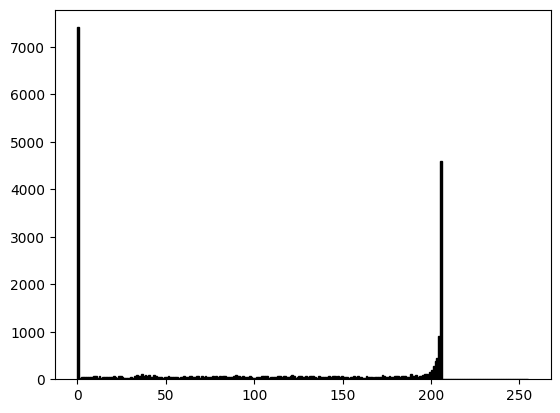

In [22]:
plt.hist(subtracted.ravel(), bins=range(256), fc='k', ec='k')

## Rotate the image

Because we should expect our model to only identify a fingerprint when it is upright, we should add some rotation.

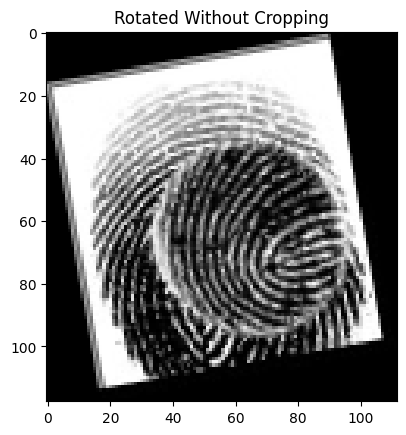

In [16]:
# rotate our image by 33 degrees counterclockwise, ensuring the
# entire rotated image still views in the viewing area
rotated = imutils.rotate_bound(image, -10)
plt_imshow("Rotated Without Cropping", rotated)

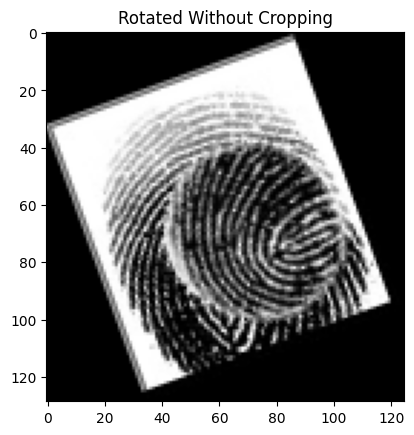

In [17]:
rotated = imutils.rotate_bound(image, -20)
plt_imshow("Rotated Without Cropping", rotated)

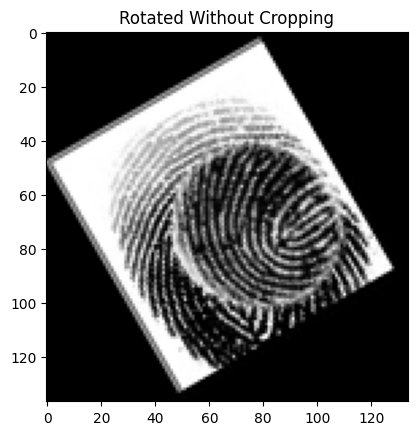

In [18]:
rotated = imutils.rotate_bound(image, -30)
plt_imshow("Rotated Without Cropping", rotated)

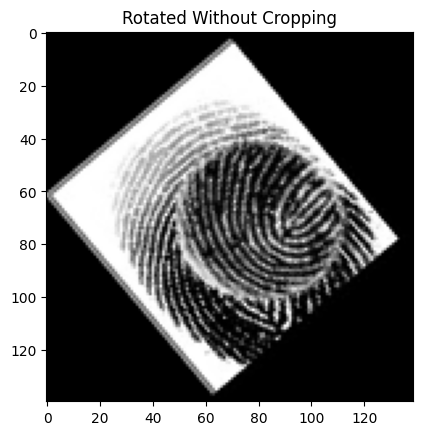

In [19]:
rotated = imutils.rotate_bound(image, -40)
plt_imshow("Rotated Without Cropping", rotated)

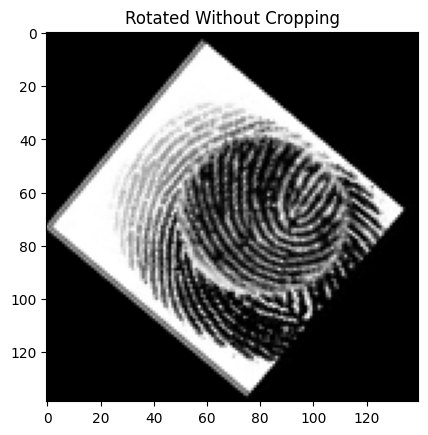

In [22]:
rotated = imutils.rotate_bound(image, -50)
plt_imshow("Rotated Without Cropping", rotated)